<a href="https://colab.research.google.com/github/cesaraugustopereirabr/Projeto_DIO_calculodemetricasdeavaliacao/blob/main/Matriz_de_confus%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

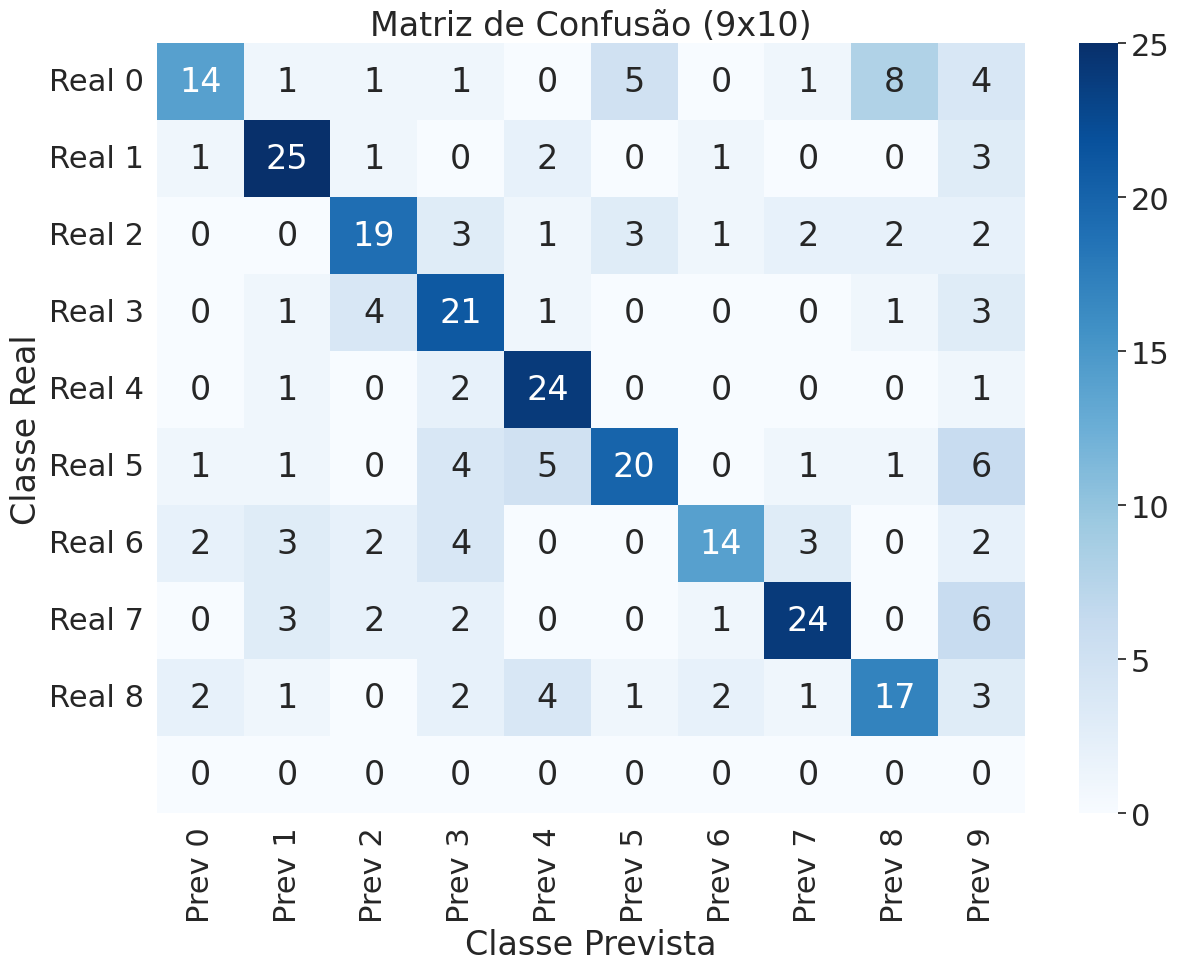

=== MÉTRICAS ===
Acurácia: 0.59
Precisão (macro): 0.60
Recall (macro): 0.54
Especificidade (média): 0.96
F1-Score (macro): 0.56


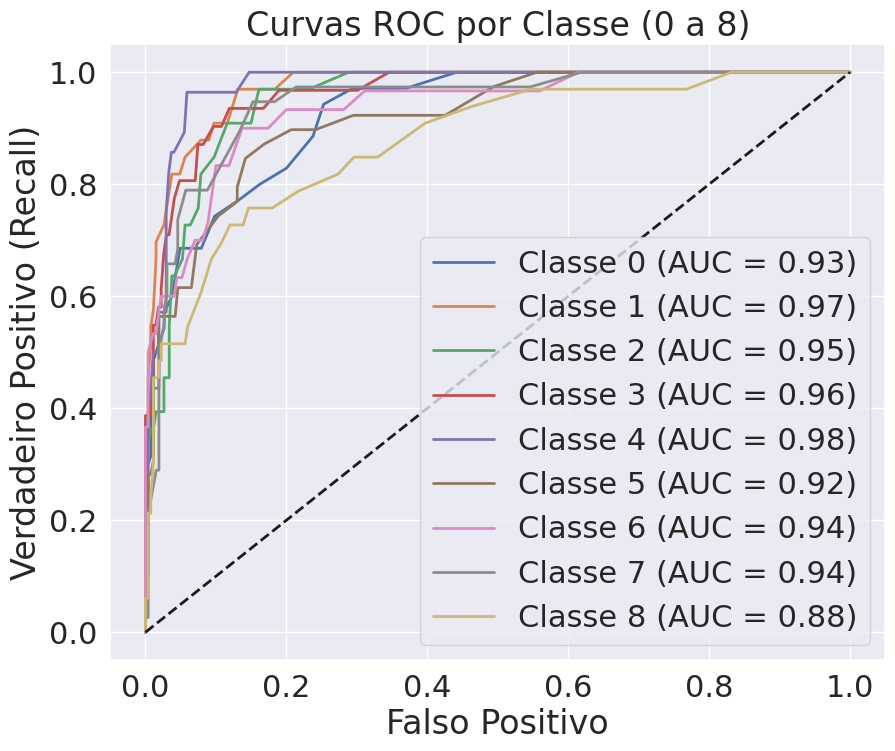

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Criar dados com 9 classes (reais)
n_classes = 9
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_classes=n_classes, n_clusters_per_class=1, random_state=42)

# Adicionar uma 10ª classe aleatória nas previsões para simular erro/ruído (classe fora do padrão)
# Transformar 10% dos rótulos de teste em classe "9" (inexistente originalmente)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Previsões
y_pred = clf.predict(X_test)

# Adicionando ruído: simular 10% das previsões como classe 9 (classe extra)
indices_noise = np.random.choice(len(y_pred), size=int(0.1 * len(y_pred)), replace=False)
y_pred[indices_noise] = 9  # classe 9 não estava entre as originais (0–8)

# Matriz de confusão (real: 0-8, prevista: 0–9)
labels_true = list(range(9))
labels_pred = list(range(10))  # inclui classe extra

cm = confusion_matrix(y_test, y_pred, labels=labels_pred)

# Plot matriz de confusão
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Prev {i}' for i in labels_pred],
            yticklabels=[f'Real {i}' for i in labels_true])
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão (9x10)')
plt.show()

# Acurácia
acuracia = accuracy_score(y_test, y_pred)

# Precisão, Recall e F1 macro (média entre classes)
precisao = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Especificidade (calculada por classe)
def calcular_especificidade(cm):
    especificidades = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        if (tn + fp) > 0:
            especificidades.append(tn / (tn + fp))
    return np.mean(especificidades)

especificidade = calcular_especificidade(cm)

# Exibir métricas
print("=== MÉTRICAS ===")
print(f"Acurácia: {acuracia:.2f}")
print(f"Precisão (macro): {precisao:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"Especificidade (média): {especificidade:.2f}")
print(f"F1-Score (macro): {f1:.2f}")

# CURVA ROC MULTICLASSE (real = 0-8)
# Binarizar os rótulos
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
y_score = clf.predict_proba(X_test)  # Probabilidades das 9 classes reais

# Calcular curva ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot das curvas ROC
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo (Recall)')
plt.title('Curvas ROC por Classe (0 a 8)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()